In [29]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# Load the data using the tempeh package
from tempeh.configurations import datasets
dataset = datasets['lawschool_passbar']()

X_train, X_test = dataset.get_X(format=pd.DataFrame)
y_train, y_test = dataset.get_y(format=pd.Series)
A_train, A_test = dataset.get_sensitive_features(name='race', format=pd.Series)

# Combine all training data into a single data frame and glance at a few rows
all_train = pd.concat([X_train, y_train, A_train], axis=1)
display(all_train)

,lsat,ugpa,pass_bar,race
0,38.0,3.1,1,white
1,45.0,2.6,1,white
2,36.0,3.6,1,white
3,37.0,3.5,1,white
4,47.0,3.3,1,white
...,...,...,...,...
13703,36.0,3.3,1,white
13704,34.0,3.5,1,white
13705,37.0,3.5,1,white
13706,40.0,3.3,1,white


In [30]:
all_train_grouped = all_train.groupby('race')

counts_by_race = all_train_grouped[['lsat']].count().rename(
    columns={'lsat': 'count'})

quartiles_by_race = all_train_grouped[['lsat','ugpa']].quantile([.25, .50, .75]).rename(
    index={0.25: "25%", 0.5: "50%", 0.75: "75%"}, level=1).unstack()

rates_by_race = all_train_grouped[['pass_bar']].mean().rename(
    columns={'pass_bar': 'pass_bar_rate'})

summary_by_race = pd.concat([counts_by_race, quartiles_by_race, rates_by_race], axis=1)
display(summary_by_race)

,count,"(lsat, 25%)","(lsat, 50%)","(lsat, 75%)","(ugpa, 25%)","(ugpa, 50%)","(ugpa, 75%)",pass_bar_rate
race,,,,,,,,
black,880,26.0,29.0,33.0,2.6,2.9,3.2,0.780682
white,12828,34.0,38.0,41.0,3.0,3.3,3.6,0.968428


## Unmitigated Predictor

We first train a standard logistic regression predictor that does not seek to incorporate any notion of fairness.

In [31]:
from sklearn.linear_model import LogisticRegression

unmitigated_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)
unmitigated_predictor.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

We view the probabilistic predictions produced by the logistic model as scores and evaluate the quality of the ranking they produce in terms of the area under the ROC curve (AUC). AUC is equal to the probability that a randomly chosen positive example (i.e., a student who passes the bar) is scored above a randomly chosen negative example (i.e., a student who does not pass the bar). An AUC of 0.5 means that the scores are no better than a random coin flip, whereas AUC of 1.0 means that the scores perfectly separate positives from negatives. The AUC metric has two desirable properties: (1) it is preserved by monotone transformations of the score, and (2) it is not sensitive to the imbalance between positives and negatives, which is quite severe in our example, with the overall bar passage rate above 94%.

Note that the logistic regression estimator above does not seek to optimize AUC directly, but only seeks to optimize the logistic loss. However, a good logistic loss is also expected to yield a good AUC.

To obtain the AUC values for the overall student population as well as black and white subpopulations, we use the group metric variant of the sklearn metric roc_auc_score.

In [121]:
from fairlearn.metrics import group_roc_auc_score

# a convenience function that transforms the result of a group metric call into a data frame
def group_metric_as_df(name, group_metric_result):
    a = pd.Series(group_metric_result.by_group)
    a['overall'] = group_metric_result.overall
    return pd.DataFrame({name: a})

scores_unmitigated = pd.Series(unmitigated_predictor.predict_proba(X_test)[:,1], name="score_unmitigated")
auc_unmitigated = group_metric_as_df("auc_unmitigated",
                                     group_roc_auc_score(y_test, scores_unmitigated, A_test))

display(HTML('<span id="auc_unmitigated">'),
        auc_unmitigated,
        HTML('</span>'))

,auc_unmitigated
black,0.747184
white,0.736673
overall,0.790532


In [122]:
def get_error(y,predicted_y):
    correct_y = (y == predicted_y)
    return 1 - sum(correct_y)/len(correct_y)

In [123]:
unmitigated_y = pd.Series(unmitigated_predictor.predict(X_test),name="unmitigated_predicted_y")
error_unmitigated = [get_error(y_test,unmitigated_y)]
print("The error for unmitigated is:")
print(error_unmitigated)

The error for unmitigated is:
[0.04783767772511849]


## Get the violation of the fairness constraints

In [125]:
def get_violation(predict_y,A_test,label_name):
    violations = []
    predicted_and_sensitiveFeature = pd.concat([predict_y,A_test],axis=1)
    grouped =predicted_and_sensitiveFeature.groupby('race')
    counts_by_race = grouped[[label_name]].count()
    passed_by_race = grouped[[label_name]].sum()
#     display(counts_by_race)
#     display(passed_by_race)
    for i,group in enumerate(grouped.groups.keys()):
        violation_1 = passed_by_race[label_name][i] / counts_by_race[label_name][i]
        violation_2 = sum(predict_y) / len(predict_y)
        violations.append(abs(violation_1 - violation_2))
    violation = max(violations)
    return violation
    
violation_unmitigated = [get_violation(unmitigated_y,A_test,'unmitigated_predicted_y')]
print("The violation for unmitigated is:")
print(violation_unmitigated)

The violation for unmitigated is:
[0.015982547851026152]


## Exp Gradients

In [135]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity
import numpy as np
# eps_list = [0.001,0.01,0.1]
eps_list = list(np.arange(0.001, 0.1, 0.001))
expgrad_error = []
expgrad_violation = []
balanced_index_pass0 = y_train[y_train==0].index 
balanced_index_pass1 = y_train[y_train==1].sample(n=balanced_index_pass0.size, random_state=0).index
balanced_index = balanced_index_pass0.union(balanced_index_pass1)

for eps in eps_list:
    expgrad_X = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    
    expgrad_X.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    
    expgrad_y = pd.Series(expgrad_X.predict(X_test),name="expgrad_predicted_y")
    error_expgrad = get_error(y_test,expgrad_y)
    expgrad_error.append(error_expgrad)
    violation_expgrad = get_violation(expgrad_y,A_test,"expgrad_predicted_y")
    expgrad_violation.append(violation_expgrad)



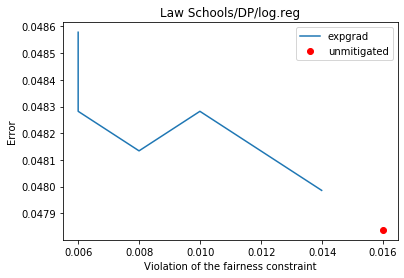

In [136]:
import matplotlib.pyplot as plt

plt.plot(expgrad_violation,expgrad_error,label="expgrad")
plt.plot(violation_unmitigated,error_unmitigated,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Law Schools/DP/log.reg')
plt.legend()
plt.show()